In [19]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import zipfile
import random

In [20]:
def load_data(filename : str, ds : str) -> pd.DataFrame:
    '''
    Load, unit, clean target data from input file
    :param filename path to source file
    :param ds name of trg xls file
    '''
    dfs = []
    
    with zipfile.ZipFile(filename, 'r') as trg_zip:  # reading and searching
        for item in trg_zip.namelist():
            if ds in item:
                with trg_zip.open(item) as trg_file:  # check trg file
                    dfs.extend(pd.read_html(trg_file, encoding='cp1250'))  # store
    
    df = pd.concat(dfs)  # all trg tabels to one
    df = df.drop(columns=[col for col in df.columns if "Unnamed" in str(col)]) # drop unnamed columns
    return df

In [21]:
accident = load_data('data_23_24.zip', 'nehody')
print(accident)

                 p1         p2a   p2b  p4a  p4b  p4c  p5a  p6  p7  p8  ...  \
0       10623000002  01.01.2023  1730    1    7   12    2   5   0   0  ...   
1       60223000039  10.01.2023   916    6    2   10    1   3   0   3  ...   
2          23000455  15.01.2023  1930    0   11   20    1   1   4   0  ...   
3       70623000019  10.01.2023   815    7    6   18    2   5   0   0  ...   
4      161723000024  11.01.2023  1730   16   17   17    2   5   0   0  ...   
...             ...         ...   ...  ...  ...  ...  ...  ..  ..  ..  ...   
69696  140824000888  04.10.2024   620   14    8   17    2   5   0   0  ...   
69697  140824000887  03.10.2024  2230   14    8   17    2   5   0   0  ...   
69698  140824000886  03.10.2024  2030   14    8   19    2   5   0   0  ...   
69699  140824000885  03.10.2024  1260   14    8   19    1   3   0   6  ...   
69700   11624000662  03.10.2024  1010    1   16   21    2   1   4   0  ...   

       p23  p24  p27  p28  p34  p35  p36      p37      p38  p39

In [22]:
df_consequences = load_data('data_23_24.zip', 'nasledky')
print(df_consequences)

                  p1  id_vozidla  p59a  p59b  p59c p59d   p59e  p59f  p59g
0           22000026           1   NaN   NaN   NaN  NaN    NaN   NaN   4.0
1           23000010           1   1.0   3.0   1.0   20  340.0   1.0   4.0
2           23000011           1   NaN   NaN   2.0   00  998.0   NaN   4.0
3           23000011           2   1.0   3.0   1.0   66   10.0   1.0   4.0
4           23000012           1   1.0   3.0   1.0   41   10.0   1.0   4.0
...              ...         ...   ...   ...   ...  ...    ...   ...   ...
117783  194024000055           1   1.0   3.0   1.0   35   10.0   1.0   4.0
117784  194024000056           1   1.0   3.0   1.0   61   10.0   1.0   4.0
117785  194024000056           1   2.0   3.0   2.0   56   10.0   1.0   4.0
117786  194024000057           1   NaN   NaN   NaN  NaN    NaN   NaN   NaN
117787  194024000057           2   1.0   3.0   1.0   49   10.0   1.0   4.0

[277728 rows x 9 columns]


In [23]:
def parse_data(df: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:
    '''
    Filters and modifies input data into a form convenient for further analysis
    
    Args:
    df (pd.DataFrame):  input data in dataframe.
    verbose (bool):     flag for size outpout data display. Defaults to False.

    Returns:
        pd.Dataframe: Parsed data
    '''
    REGION_DICT = {0: "PHA", 1: "STC", 2: "JHC", 3: "PLK", 4: "ULK", 5: "HKK",6:
    "JHM", 7: "MSK", 14: "OLK", 15: "ZLK", 16: "VYS", 17: "PAK", 18:
    "LBK", 19: "KVK"}
    
    new_df = df.copy()
    new_df['date'] = pd.to_datetime(df['p2a'], dayfirst=True, yearfirst=False, format=None, errors='coerce')  # formate for date
    new_df['region'] = new_df['p4a'].apply(lambda x: REGION_DICT[x])  # create readable region col 

    new_df.drop_duplicates(subset=['p1'], inplace=True)  # drop duplicates by p16 col
    
    if verbose:  # display new mem storage
        new_size = new_df.memory_usage(deep=True).sum()/1_000_000
        print(f'new_size={new_size:.1f} MB')
    
    return new_df


In [24]:
df_accident = parse_data(accident, True)

new_size=69.6 MB


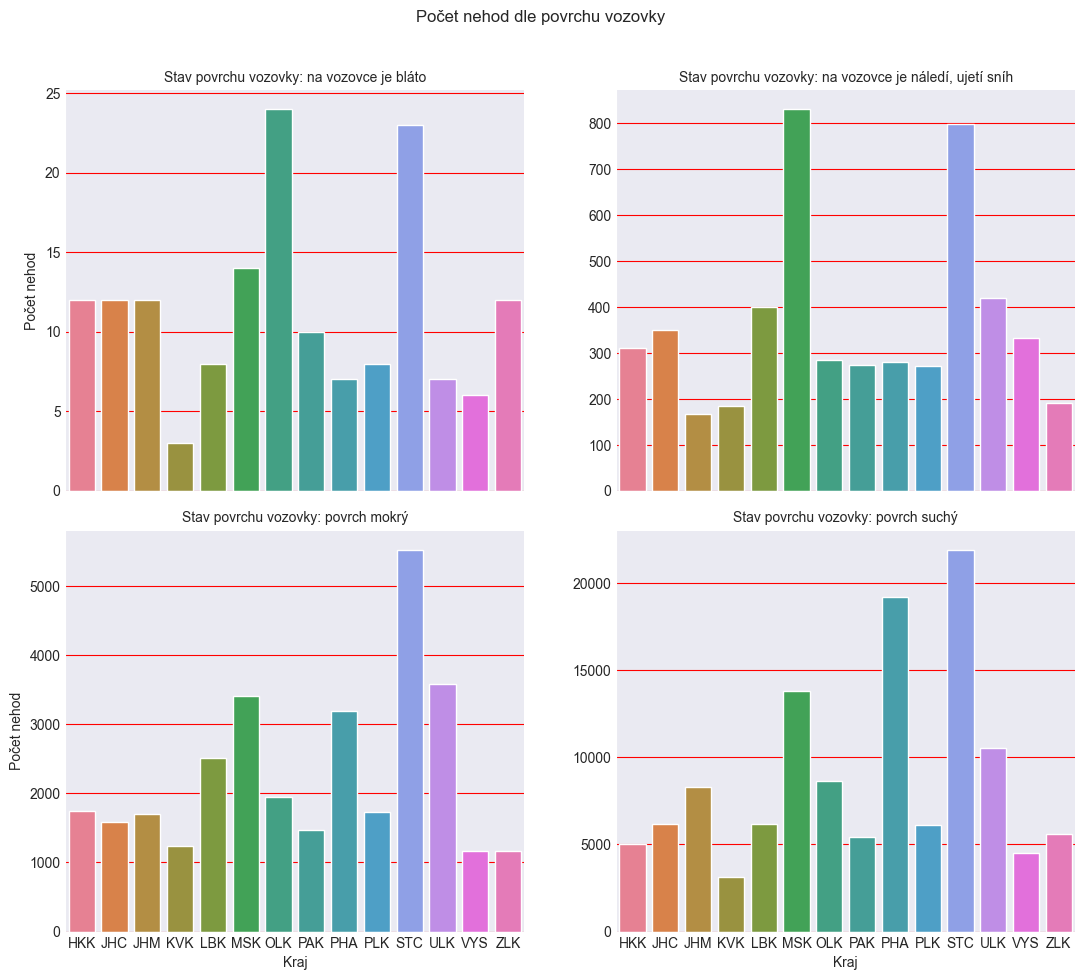

In [25]:
# Ukol 3: počty nehod v jednotlivých regionech podle stavu vozovky
def plot_state(df: pd.DataFrame, fig_location: str = None,
                    show_figure: bool = False)->None:
    '''
    Create accident number chart and save it on target file with optional displaying.
    
    Args:
        df (pd.DataFrame): input data for accident.
        fig_location (str|None, optional): path/name for target file for saving. Defaults to None.
        show_figure (bool): flag for optional displaying. Defaults to False.

    Returns:
        None
    '''
    # aux const
    DICT_SURFACE_CONDITION = {1:'povrch suchý', 2:'povrch suchý', 3:'povrch mokrý', 4: 'na vozovce je bláto', 5:'na vozovce je náledí, ujetí sníh', 6:'na vozovce je náledí, ujetí sníh'}
    SURFACE_CONDITION = set(DICT_SURFACE_CONDITION.values())
    
    df_aux = df.copy()  # new df
    df_aux['p16'] = df_aux['p16'].replace(DICT_SURFACE_CONDITION)  # transform surface condition to trg string
    df_aux = df_aux[df_aux['p16'].isin(SURFACE_CONDITION)].groupby(['region', 'p16']).count()['p1'].reset_index(name='pocet nehod')  # agrigation

    # plotting
    plt.rcdefaults()
    sns.set_style("darkgrid", {"grid.color": "red"})
    statistic = sns.catplot(data=df_aux, x='region', y='pocet nehod', hue='region', kind='bar', col='p16', sharey=False, col_wrap=2, aspect=1.1)
    statistic.figure.suptitle('Počet nehod dle povrchu vozovky')
    statistic.figure.subplots_adjust(top=0.9)
    statistic.set_axis_labels('Kraj', 'Počet nehod')
    statistic.set_titles('Stav povrchu vozovky: {col_name}')
    statistic.tick_params(width=0,length=0)
    plt.subplots_adjust(wspace=0.2)
    
    # save and display
    if show_figure:
        plt.show()
    if fig_location is not None:
        plt.savefig(fig_location)

plot_state(df_accident, 'stav')

In [26]:
# Ukol4: alkohol a následky v krajích
def plot_alcohol(df: pd.DataFrame, df_consequences : pd.DataFrame, 
                 fig_location: str = None, show_figure: bool = False)->None:
    '''
    Create accident by alcohol dependency chart and save it on target file with optional displaying.

    Args:
        df (pd.DataFrame): source data frame about accident.
        df_consequences (pd.DataFrame): source data frame about consequences.
        fig_location (str|None): path to save file. Defaults to None.
        show_figure (bool): optional flag about displaying. Defaults to False.
    
    Returns:
        None
    '''
    # aux const
    ACCIDENT_CONSEQUENCES = ['Usmrcení', 'Těžké zranění', 'Lehké zranění', 'Bez zranění']

    # merge dataframes with 1:m by p1
    df_aux = df.merge(df_consequences, on='p1', how='inner', validate='1:m')
    
    # preparation
    df_aux = df_aux[df_aux['p11']>=3]  # accident by alcohol
    df_aux['obet'] = df_aux['p59a'].apply(lambda x: 'Řidič' if x == 1 else 'Spolujezdec')  # readable format about victim
    df_aux['druh_nasledku'] = pd.cut(df_aux['p59g'], bins=[0, 1, 2, 3, 4], labels=ACCIDENT_CONSEQUENCES)  # categorization of accident consenquences
    
    # agrigation
    df_aux = df_aux.groupby(['druh_nasledku', 'obet', 'region'], observed=False).count()['p1'].reset_index()
    
    # plot
    plt.rcdefaults()
    sns.set_style("darkgrid")
    statistic = sns.catplot(x='region', y='p1', col='druh_nasledku', hue="obet", data=df_aux, kind="bar", col_wrap=2,
                            aspect=1.1,saturation=0.5,hue_order=['Řidič', 'Spolujezdec'], legend=True, sharey=False, 
                            col_order=['Bez zranění', 'Lehké zranění', 'Těžké zranění', 'Usmrcení'])
    statistic.set_titles('Nasledek nehody: {col_name}')
    statistic.set_axis_labels('Kraj', 'Počet nehod pod vlivem alkoholu')
    statistic.legend.set_title(None)
    statistic.set_ylabels('Počet nehod pod vlivem alkoholu')
    plt.subplots_adjust(wspace=0.2)
    for ax in statistic.axes.flat:
        ax.set_ylabel('Počet nehod pod vlivem alkoholu')
    
    # save and display
    if show_figure:
        plt.show()
    if fig_location is not None:
        statistic.savefig(fig_location)

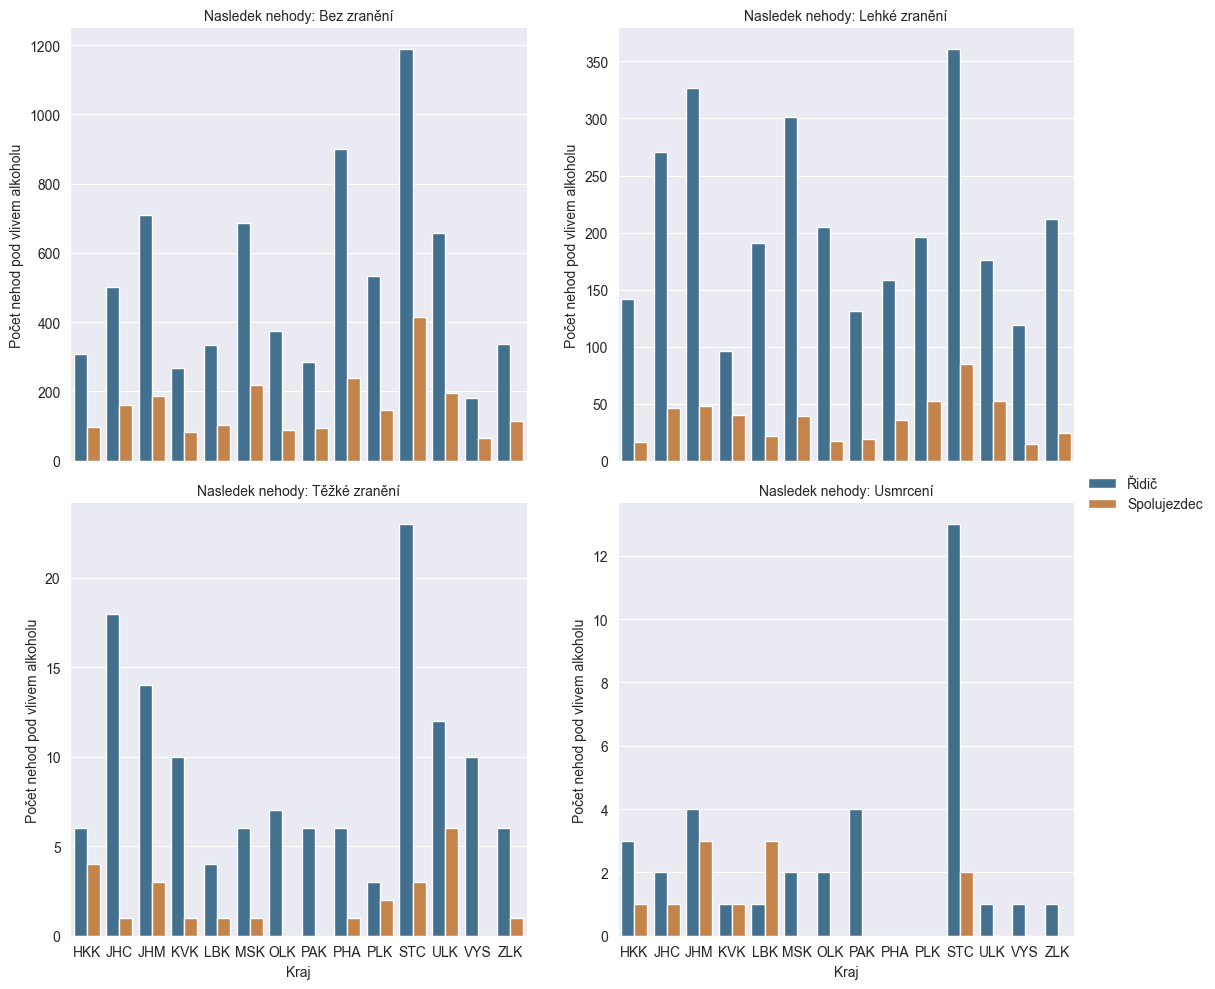

In [27]:
plot_alcohol(df_accident, df_consequences, 'alcohol', True)

In [30]:
# Ukol 5: Druh nehody (srážky) v čase
def plot_type(df: pd.DataFrame, fig_location: str = None,
              show_figure: bool = False)->None:
    '''
    Create accident plot throw time with optional saving and displaying.
    
    Args:
        df (pd.DataFrame): source data frame about accident.
        fig_location (str|None): path to save file. Defaults to None.
        show_figure (bool): optional flag about displaying. Defaults to False.
    
    Returns:
        None
    '''
    
    # aux const
    TRG_REGION = ['PHA', 'STC', 'JHC', 'PLK']
    CONDITION = ['s jedoucím nekolejovým vozidlem', 
                 's vozidlem zaparkovaným, odstaveným',
                 's pevnou překážkou',
                 's chodcem',
                 's lesní zvěří',
                 's domácím zvířetem',
                 's vlakem',
                 's tramvají']
    # prepare
    df_aux = df.copy()
    df_aux = df_aux[df_aux['region'].isin(TRG_REGION)]  # only my region
    df_aux = df_aux[(df_aux['p6'] > 0) & (df_aux['p6'] < 9)]  # only known category of accident
    df_aux['druh nehody'] = pd.cut(df_aux['p6'], [0,1,2,3,4,5,6,7,8], labels=CONDITION)  # categorize type of accident
    
    # table transforms
    df_aux = pd.pivot_table(data=df_aux, index=['date', 'region'], values='p1', columns='druh nehody', aggfunc='count', observed=True)  # pivot with indexing on date and region with count of accidents
    df_aux = df_aux.groupby(['region', pd.Grouper(freq='ME', level='date')]).sum()  # agrigation by region and date in month format
    df_aux = df_aux.stack().reset_index()  # stacking
    df_aux = df_aux.rename(columns={0:'pocet nehod'})  # readable format for accident counting
    
    # plot
    plt.rcdefaults()
    statistic = sns.relplot(x='date', y='pocet nehod', col='region', hue="druh nehody", data=df_aux, kind="line", col_wrap=2)
    statistic.set_titles('Kraj: {col_name}')
    statistic.set_ylabels('Počet nehod')
    statistic.legend.set_label('Druh nehody')
    statistic.tick_params(axis='x', rotation=45, which='both', length=5)
    statistic.tick_params(axis='y', which='both', length=5)
    for ax in statistic.axes.flat:
        ax.set_xlabel(None)
        ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-10-01'))
    
    if show_figure:
        plt.show()
    if fig_location is not None:
        statistic.savefig(fig_location)

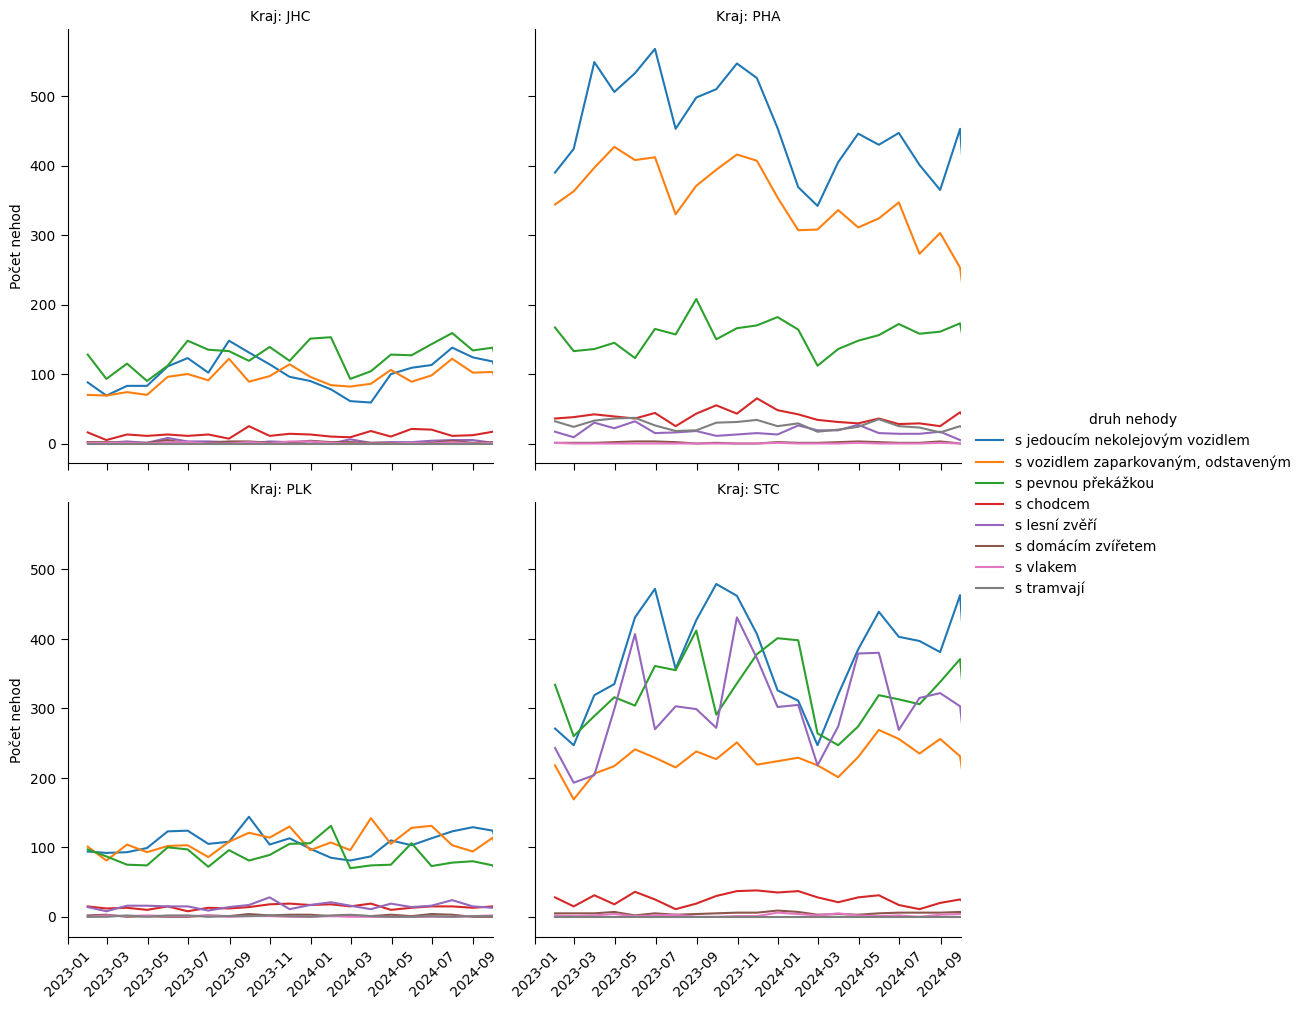

In [31]:
plot_type(df_accident, show_figure=True)